## Animal Image Classification Using EfficientNet



In [17]:
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import splitfolders
import random
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn
from torch.optim import Adam
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix
from torch.cuda.amp import autocast, GradScaler

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [ ]:
splitfolders.ratio("C:/Users/USER/Downloads/animal_data",
            output="data",
            seed=42,
            ratio=(.6, .2, .2),
            group_prefix=None,
            move=False)


In [55]:
img_size=224
img_mean = [0.485, 0.456, 0.406]
img_std = [0.229, 0.224, 0.225]
# Tranformations
transform_train_aug = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.3, saturation=0.3, contrast=0.3, hue=0.03),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ToTensor(),  
    transforms.Normalize(mean=img_mean, std=img_std),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2)),  
])

val_test_transform=transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=img_mean,std=img_std)
])

#Load Dataset
train_data=datasets.ImageFolder(root="C:/Users/USER/Documents/WORLD QUANT PROJECT/Fundamental deep learning/Chapter 6 PreTrained ResNet CNN/data/train",
                                transform=transform_train_aug)
val_data=datasets.ImageFolder(root="C:/Users/USER/Documents/WORLD QUANT PROJECT/Fundamental deep learning/Chapter 6 PreTrained ResNet CNN/data/val",
                              transform=val_test_transform)
test_data=datasets.ImageFolder(root="C:/Users/USER/Documents/WORLD QUANT PROJECT/Fundamental deep learning/Chapter 6 PreTrained ResNet CNN/data/test",
                              transform=val_test_transform)

# Data Loader
batch_size=32

train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True)
val_loader=DataLoader(val_data,batch_size=batch_size,shuffle=False)
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)

# Verify Class Mapping & Sizes

print(f"Classes: {train_data.classes}")
print(f"Train samples: {len(train_data)} | Val samples: {len(val_data)} | Test samples: {len(test_data)}")

Classes: ['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']
Train samples: 3240 | Val samples: 1080 | Test samples: 1080


## Explore

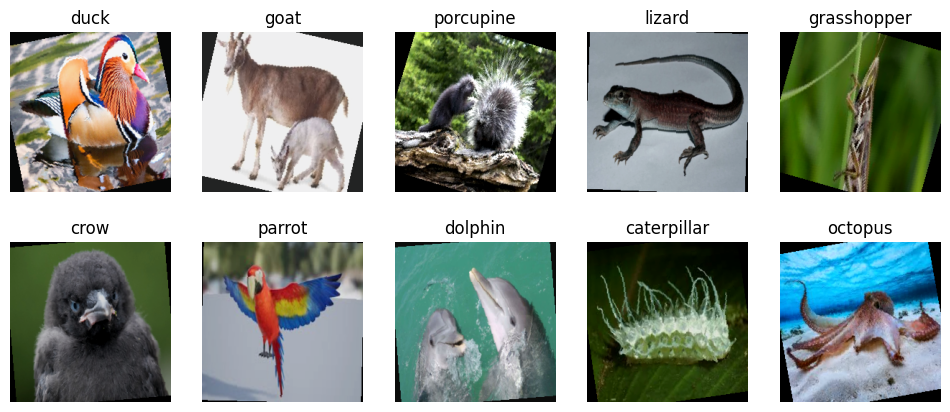

In [21]:
# Visualization (unnormalise for display)

def unnormalise(inp,title=None,ax=None):
     """Display a tensor image after unnormalizing (ImageNet stats)."""
     inp=inp.numpy().transpose((1,2,0))
     inp=img_std*inp+img_mean
     inp=np.clip(inp,0,1)
     plt.imshow(inp)
     if ax is None:
        plt.imshow(inp)
     else:
        ax.imshow(inp)
        
     if title is not None:
        if ax is None:
            plt.title(title)
        else:
            ax.set_title(title)
    
     if ax is not None:
        ax.axis("off")
     else:
        plt.axis("off")

# show first 10 training images
image,label=next(iter(train_loader))
fig=plt.figure(figsize=(12,5))
for i in range(10):
     ax=fig.add_subplot(2,5,i+1)
     unnormalise(image[i], title=train_data.classes[label[i]], ax=ax)
plt.show()   
     

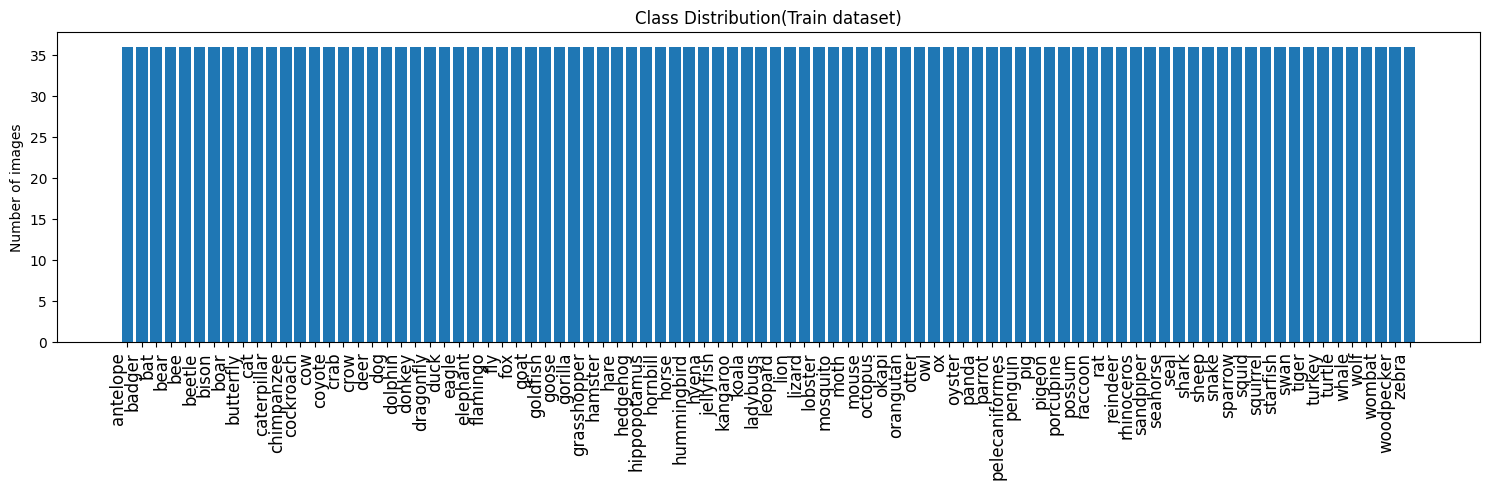

In [22]:
# Count samples per class
class_count=collections.Counter([label for _,label in train_data.samples])
counts=[class_count[i] for i in range(len(train_data.classes))]
plt.figure(figsize=(15,5))
plt.bar(train_data.classes,counts)
plt.xticks(rotation=90,fontsize=12,ha="right") 
plt.ylabel("Number of images")
plt.title("Class Distribution(Train dataset)")
plt.tight_layout()
plt.show()

## Deep Model

In [ ]:
from torchvision.models import efficientnet_b1
import torch.nn as nn

# Load EfficientNet architecture without pretrained weights
model = efficientnet_b1(weights=None)

# Load the manually downloaded weights
state_dict = torch.load("C:/Users/USER/Downloads/efficientnet_b1_rwightman-bac287d4.pth")
model.load_state_dict(state_dict)

#  FINE-TUNING: Freeze early blocks, unfreeze last 3 blocks
for i in range(6):  # Freeze blocks 0-5
    for param in model.features[i].parameters():
        param.requires_grad = False

for i in range(6, 9):  # Unfreeze blocks 6-8
    for param in model.features[i].parameters():
        param.requires_grad = True

# Replace classifier for 90 classes
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(in_features, 90) 
)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

Trainable parameters: 5,422,582


In [56]:
import torch.optim as optim
import copy
import time
from tqdm import tqdm
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Loss Function
criterion=nn.CrossEntropyLoss(label_smoothing=0.1)
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
# Decays LR by factor of 0.1 every 7 epochs
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

def train_val_model(model,criterion,optimizer,scheduler,train_loader,val_loader,num_epochs=5,device="cpu"):
    best_model_weight=copy.deepcopy(model.state_dict())
    best_loss=float("inf")

    history={"train_loss":[],"train_acc":[],"val_loss":[],"val_acc":[]}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-"*20)

        for phase in ["train","val"]:
            if phase=="train":
                model.train()
                loader=train_loader
            else:
                model.eval()
                loader=val_loader
            running_loss=0.0
            running_correct=0
            total_samples=0

            for images,labels in loader:
                images,labels=images.to(device),labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=="train"):
                    output=model(images)
                    loss=criterion(output,labels)

                    if phase=="train":
                        loss.backward()
                        optimizer.step()
                # stat 
                running_loss+= loss.item()*images.size(0)
                running_correct+= (output.argmax(1)==labels).sum().item()
                total_samples+=labels.size(0)

            epoch_loss=running_loss/total_samples
            epoch_acc=running_correct/total_samples

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc)   

            # Track best model (lowest val loss)
            if phase=="val" and epoch_loss<best_loss:
                best_loss=epoch_loss
                best_model_weight=copy.deepcopy(model.state_dict())
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        
        scheduler.step()
        print()
    print(f'Best val loss: {best_loss:.4f}')
    # Load best weight
    model.load_state_dict(best_model_weight)

    return model,history
# Train the model
model, history_transfer = train_val_model(
        model, criterion, optimizer, scheduler,
        train_loader, val_loader,
        num_epochs=15, device='cpu')

#torch.save(model.state_dict(), "resnet18_mine_student.pth")




Epoch 1/15
--------------------
Train Loss: 4.2927 Acc: 0.1096
Val Loss: 3.9164 Acc: 0.4611

Epoch 2/15
--------------------
Train Loss: 3.5125 Acc: 0.4497
Val Loss: 3.0313 Acc: 0.6972

Epoch 3/15
--------------------
Train Loss: 2.7709 Acc: 0.6160
Val Loss: 2.4092 Acc: 0.7602

Epoch 4/15
--------------------
Train Loss: 2.4076 Acc: 0.6753
Val Loss: 2.2100 Acc: 0.7824

Epoch 5/15
--------------------
Train Loss: 2.2546 Acc: 0.7080
Val Loss: 2.1826 Acc: 0.7815

Epoch 6/15
--------------------
Train Loss: 2.0616 Acc: 0.7247
Val Loss: 1.7333 Acc: 0.8222

Epoch 7/15
--------------------
Train Loss: 1.7420 Acc: 0.7793
Val Loss: 1.5546 Acc: 0.8454

Epoch 8/15
--------------------
Train Loss: 1.5758 Acc: 0.8114
Val Loss: 1.4432 Acc: 0.8556

Epoch 9/15
--------------------
Train Loss: 1.4471 Acc: 0.8429
Val Loss: 1.3582 Acc: 0.8648

Epoch 10/15
--------------------
Train Loss: 1.3575 Acc: 0.8688
Val Loss: 1.3312 Acc: 0.8787

Epoch 11/15
--------------------
Train Loss: 1.3050 Acc: 0.8759
Val L

In [73]:
# Save and Load model
# torch.save(model.state_dict(),"efficient_mine.pth")
model.load_state_dict(torch.load("efficient_mine.pth"))

<All keys matched successfully>

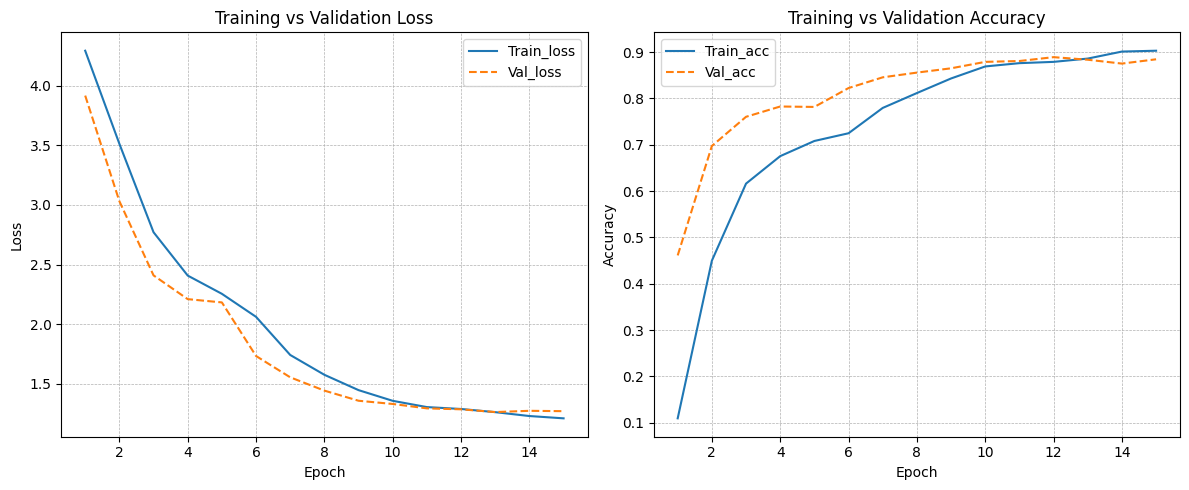

In [71]:
# Visualize train and val model
epoch=range(1,len(history_transfer["train_loss"])+1)

#loss plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epoch,history_transfer["train_loss"],label="Train_loss")
plt.plot(epoch,history_transfer["val_loss"],label="Val_loss",linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True,linestyle="--",linewidth=0.5)
plt.legend()

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(epoch,history_transfer["train_acc"],label="Train_acc")
plt.plot(epoch,history_transfer["val_acc"],label="Val_acc",linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.grid(True,linestyle="--",linewidth=0.5)
plt.legend()

plt.tight_layout()
plt.show()

In [74]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
def evaluate_model(model,loader,device="cpu"):
    model.eval()
    all_labels,all_preds=[],[]
    with torch.no_grad():
        for images,labels in loader:
            images,labels=images.to(device),labels.to(device)
            output=model(images)
            preds=output.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc=accuracy_score(all_labels,all_preds)  
    return acc,np.array(all_labels),np.array(all_preds)  

# Evaluate model
test_acc,y_true,y_pred=evaluate_model(model,test_loader,device="cpu")   
print(f"EfficientNet_bo Transfer Learning Test Accuracy: {test_acc:.2%}")

EfficientNet_bo Transfer Learning Test Accuracy: 87.41%


In [67]:
#  Classification Report
# -----------------------------
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_data.classes))






Classification Report:
                precision    recall  f1-score   support

      antelope       0.69      0.92      0.79        12
        badger       0.92      1.00      0.96        12
           bat       0.85      0.92      0.88        12
          bear       0.82      0.75      0.78        12
           bee       1.00      0.92      0.96        12
        beetle       0.85      0.92      0.88        12
         bison       1.00      0.83      0.91        12
          boar       1.00      0.83      0.91        12
     butterfly       0.69      0.92      0.79        12
           cat       0.92      0.92      0.92        12
   caterpillar       0.77      0.83      0.80        12
    chimpanzee       1.00      1.00      1.00        12
     cockroach       0.92      1.00      0.96        12
           cow       0.62      0.67      0.64        12
        coyote       0.85      0.92      0.88        12
          crab       1.00      1.00      1.00        12
          crow       0.